<a href="https://colab.research.google.com/github/celiaferreira/Covid19_RX/blob/master/8_1_TransferLearning_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 8.1. Transfer learning

Nesta secção avalia-se o poder preditivo de redes pré-treinadas: **InceptionResNetV2** e **ResNet50**.

•	As camadas convolucionais mais próximas da camada de entrada do modelo aprendem features de baixo nível, como linhas.

•	As camadas intermédias aprendem features abstratas e complexas que combinam as features de nível inferior extraídas da entrada. 

•	As camadas mais próximas da saída interpretam as features extraídas no contexto de uma tarefa de classificação.

Assim, ao usar pesos de redes pré-treinadas, pode ser conveniente permitir a sua atualização para melhor ajuste ao problema.




### 8.1.1. InceptionResNetV2: pesos imagenet | Não treináveis

O primeiro modelo usa a rede InceptionResNetV2. Iremos usar os pesos pré-treinados imagenet e calcular as saídas de redes pré-treinadas para os nossos casos de treino. Estas saídas serão usadas como entradas numa rede complementamente ligada, que será treinada. Não se permitirá que a parte de feature extraction seja retreinada.

Uma vez que as imagens de Raio-X são muito distintas das imagens *imagenet*, antecipamos que seja necessário um treino dos pesos das camadas convolucionais.


In [ ]:
from keras.applications import InceptionResNetV2, ResNet50
InceptionResNetV2_model1 = InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(200,200,3))
#Inception-ResNet-v2 combines the advantages of Inception networks and residual connections to achieve state-of-the-art accuracy on the ILSVRC image classification benchmark

219062272/219055592 [==============================] - 5s 0us/step


Uma vez que as nossas imagens de input já se encontram pré-processadas, apenas serão convertidas em RGB e avaliar-se-á o poder preditivo da rede **InceptionResNetV2**, para evitar uma nova inportação sem qualquer pré-processamento.

In [ ]:
#By default, the model expects color input images to be rescaled to the size of 224×224 squares.

X_over3_rgb = X_over3.reshape(len(y_over3),200,200)

print(X_over3_rgb.shape) 
X_over3_rgb = np.repeat(X_over3_rgb[..., np.newaxis], 3, -1)
print(X_over3_rgb.shape)

X_val_rgb = X_val.reshape(len(y_val3),200,200)
X_val_rgb = np.repeat(X_val_rgb[..., np.newaxis], 3, -1)
print(X_val_rgb.shape)

X_test_rgb = X_test.reshape(len(y_test3),200,200)
X_test_rgb = np.repeat(X_test_rgb[..., np.newaxis], 3, -1)
print(X_test_rgb.shape)

Apresentamos o modelo que usa a rede InceptionResNetV2, conjugando com camadas de dropout para minimizar o overfitting. Identifica-se também que os pesos das camadas convolucionais não devem ser treinados.

In [ ]:
headModel = InceptionResNetV2_model1.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)

headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.5)(headModel)
headModel=Dense(16,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel) 
headModel=Dense(3,activation='softmax')(headModel)
model11 = Model(inputs=InceptionResNetV2_model1.input, outputs=headModel)

for layer in InceptionResNetV2_model1.layers:
    layer.trainable = False

model11.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])

In [ ]:
history11=model11.fit(X_over3_rgb, y_over3, epochs=20, validation_data=(X_val_rgb,y_val3), callbacks = callbacks, verbose=0)

Predicted    0    1    2
Actual                  
0          193  132    5
1            1  754  148
2            0  115  759
accuracy total: 0.8096820123398196
precision covid: 0.9948453608247423
recall covid: 0.5848484848484848
precision total: 0.8601096520589196
recall total: 0.7627546667938345
label precision recall
    0     0.995  0.585
    1     0.753  0.835
    2     0.832  0.868
2107/2107 [==============================] - 10s 5ms/step
[0.5115011525369109, 0.8096820116043091]


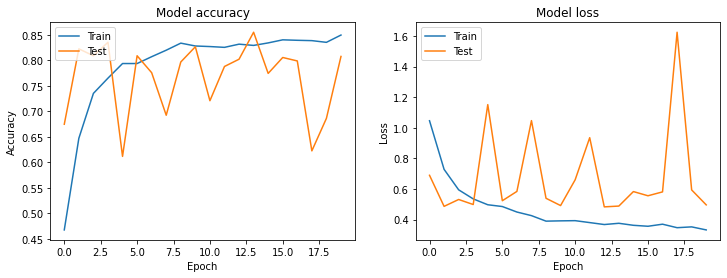

In [ ]:
output_metrics_b(model11,history11,X_test_rgb, y_test3)

O modelo atinge uma performance global de 81%, mais baixo que os modelos anteriores. Porém, o maior problema é o recall do COVID: apenas 58,5% dos casos são identificados, o que e muito pobre, apesar do treino durante 18 epochs.

Os gráficos apresentam também uma maior instabilidade no conjunto de validação, assim como overfitting, apesar das camadas de dropout utilizadas.

Como esperado, os pesos/features aprendidos no imagenet não estão a ser muito úteis para identificar o COVID em imagens de Raio-X.

### 8.1.2. InceptionResNetV2: pesos imagenet | Treináveis

Embora usando os pesos do *imagenet*, nesta seação permitiremos que as últimas camadas (que aprendem aspetos mais específicos dos problemas em análise) possam ser retreinadas.

Identifiquemos o nome das camadas da rede:

In [ ]:
#InceptionResNetV2_model1.summary()

Permitiremos o treino das camadas **block8_10_conv**, **conv_7b** e **conv_7b_bn** (foram treinados também outas redes, mas os resultados não melhoraram):

In [ ]:
InceptionResNetV2_model1.trainable = True
#treinar últimos layers
set_trainable = False
for layer in InceptionResNetV2_model1.layers:
    if layer.name in ( 'block8_10_conv', 'conv_7b','conv_7b_bn'):
      #'block8_9_conv', 'conv2d_201', 'conv2d_202', 'conv2d_200', 'conv2d_203',
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
                
headModel = InceptionResNetV2_model1.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.5)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.5)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model11b = Model(inputs=InceptionResNetV2_model1.input, outputs=headModel)

model11b.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])

In [ ]:
history11b=model11b.fit(X_over3_rgb, y_over3, epochs=20,validation_data=(X_val_rgb,y_val3), callbacks = callbacks,verbose=0)

Epoch 00019: early stopping


Predicted    0    1    2
Actual                  
0          280   30   20
1          199  313  391
2           65  151  658
accuracy total: 0.593735168485999
precision covid: 0.5147058823529411
recall covid: 0.8484848484848485
precision total: 0.587945884185679
recall total: 0.6493225434207819
label precision recall
    0     0.515  0.848
    1     0.634  0.347
    2     0.616  0.753
2107/2107 [==============================] - 10s 5ms/step
[4.539995085304814, 0.5937351584434509]


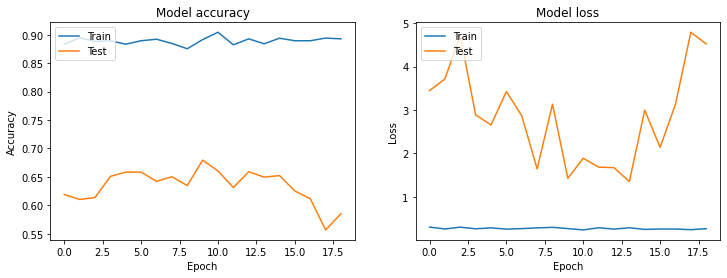

In [ ]:
output_metrics_b(model11b,history11b,X_test_rgb, y_test3)

Ao fim de 19 epochs, o modelo atinge uma performance global ainda inferior: 59,4%, mas identificando 84,4% casos COVID: o modelo erra menos no COVID, mas mais no geral. Revela ainda um elevado overfitting. Conclui-se assim que a utilização direta dos pesos do *imagenet* não apresenta bons resultados no nosso probelma.

### 8.1.3. InceptionResNetV2: usar topologia | Pesos treináveis

Nesta secção vamos usar a arquitetura do modelo pré-treinado **InceptionResNetV2** no nosso dataset, mas sem usar os pesos pré-treinados: o modelo será inicializado com pesos aleatórios e treinado de raíz. Para tal, configura-se o argumento **weights=None**, em vez de weights='Imagenet'.

In [ ]:
#Inception-ResNet-v2 combines the advantages of Inception networks and residual connections to achieve state-of-the-art accuracy on the ILSVRC image classification benchmark

Nesta abordagem usaremos apenas a arquitetura da rede InceptionResNetV2 no nosso conjunto de dados, mas sem usar os pesos pré-treinados, que serão inicializados aleatoriamente e re-treinandos de raíz.

In [ ]:
InceptionResNetV2_model = InceptionResNetV2(weights=None, include_top=False,	input_tensor=Input(shape=(200, 200, 1)))

Ao modelo conjugámos camadas de dropout para controlar o overfitting e a camada habitual fully-connected.

In [ ]:
headModel = InceptionResNetV2_model.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model11c = Model(inputs=InceptionResNetV2_model.input, outputs=headModel)

Damos indicação para treinar os pesos e iniciamos o treino:

In [ ]:
InceptionResNetV2_model.trainable = True

model11c.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history11c=model11c.fit(X_over3, y_over3, epochs=50,validation_data=(X_val,y_val3),callbacks = callbacks, verbose=0)

Epoch 00020: early stopping


Predicted    0    1    2
Actual                  
0          325    6    7
1           19  803   80
2            6   15  846
accuracy total: 0.9368770764119602
precision covid: 0.9285714285714286
recall covid: 0.9615384615384616
precision total: 0.9366128010845959
recall total: 0.9425203035634295
label precision recall
    0     0.929  0.962
    1     0.975  0.890
    2     0.907  0.976
2107/2107 [==============================] - 9s 4ms/step
[0.2698990872362297, 0.9368770718574524]


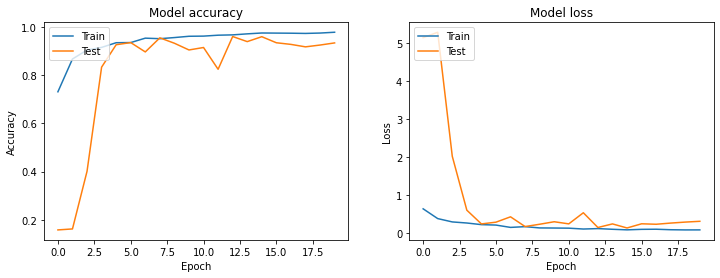

In [ ]:
output_metrics(model11c,history11c,X_test, y_test3)

Este modelo origina resultados interessantes:

* performance global de 93,7%
* recall COVID: 96,2%
* ausência de overfitting

Isto porque os pesos foram treinados desde a camada extratora de features para o nosso problema.

### 8.1.4. ResNet50: Frozen layers

Nesta secção usamos mais um modelo de TL: o ResNet50, para comparar a performance com a rede anterior.

Começamos por importar os pesos da rede Resnet50:

In [ ]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

from keras.utils.data_utils import get_file
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')


94658560/94653016 [==============================] - 2s 0us/step


Transformar imagens em RGB (3 canais), para usar weights de redes pré-treinadas.

In [ ]:
print(X_train.shape)
X_train2 = X_train.reshape(len(y_train3),200,200)
X_train2 = np.repeat(X_train2[..., np.newaxis], 3, -1)
print(X_train2.shape)  

print(X_val.shape)
X_val2 = X_val.reshape(len(y_val3),200,200)
X_val2 = np.repeat(X_val2[..., np.newaxis], 3, -1)
print(X_val2.shape)  


print(X_test.shape)
X_test2 = X_test.reshape(len(y_test3),200,200)
X_test2 = np.repeat(X_test2[..., np.newaxis], 3, -1)
print(X_test2.shape) 

print(X_over3.shape)
X_over2 = X_over3.reshape(len(y_over3),200,200)
X_over2 = np.repeat(X_over2[..., np.newaxis], 3, -1)
print(X_over2.shape)  

(3441, 200, 200, 1)
(3441, 200, 200, 3)
(1475, 200, 200, 1)
(1475, 200, 200, 3)
(2107, 200, 200, 1)
(2107, 200, 200, 3)
(4494, 200, 200, 1)
(4494, 200, 200, 3)


Iremos usar os pesos importados da camada concolucional, excluíndo a camada fully-connected, de classificação, da rede resnet50.

In [ ]:
ResNet50_model = ResNet50(weights=weights_path, include_top=False,	input_tensor=Input(shape=(200, 200, 3)))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Especificamos o modelo conjugando a rede Resnet50 com camadas de dropout e fully-connected:

In [ ]:
headModel = ResNet50_model.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model12 = Model(inputs=ResNet50_model.input, outputs=headModel)

Indicamos que os pesos da camada convolucional não devem ser re-treinados e iniciamos o treino do modelo:

In [ ]:
ResNet50_model.trainable = False

model12.compile(optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history12=model12.fit(X_over2, y_over3, epochs=50,validation_data=(X_val2,y_val3), verbose=0, callbacks = callbacks)

Epoch 00017: early stopping


Predicted    0    1    2
Actual                  
0          336    0    2
1          176  253  473
2           33    3  831
accuracy total: 0.6739439962031324
precision covid: 0.6165137614678899
recall covid: 0.9940828402366864
precision total: 0.7470296796776581
recall total: 0.744349384588418
label precision recall
    0     0.617  0.994
    1     0.988  0.280
    2     0.636  0.958
2107/2107 [==============================] - 7s 3ms/step
[1.31810581073073, 0.6739439964294434]


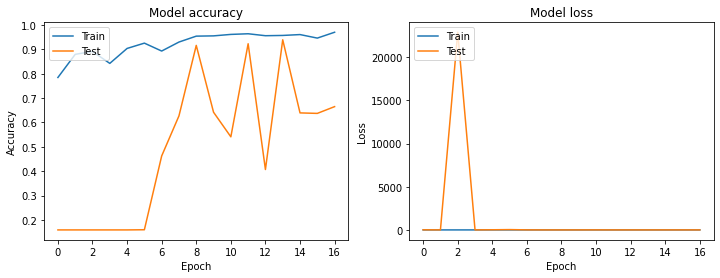

In [ ]:
output_metrics(model12,history12,X_test2, y_test3)

* O modelo apresenta uma performance global de 67,4%, com um recall muito interessante de 99,4% no COVID, embora a precisão COVID seja de apenas 61,7%.

* Adicionalmente, observa-se overfitting.

Assim, este modelo com pesos não treináveis também não apresenta resultados satisfatórios.

### 8.1.5.  ResNet50: Fine-tune Layers

Para a rede ResNet50, vamos permitir o fine-tuning das últimas 6 camadas da rede (res5b_branch2a, res5b_branch2b, res5b_branch2c, res5c_branch2a, res5c_branch2b, res5c_branch2c).

In [ ]:
#print(ResNet50_model.summary())


O descongelamento dos layer iniciais não é aconselhável porque estes são mais genéricos e reutilizáveis, enquanto os layers finais extraem features mais especializadas, mais dependentes dos dados do treino e do problema em análise.
Adicionalmente, o treino de mais parâmetros potencia o risco de overfitting.


**Definição dos layers a re-treinar:**

In [ ]:
ResNet50_model.trainable = True
#treinar 2 últimor layers 'identity', com 3 camadas convolucionais cada
set_trainable = False
for layer in ResNet50_model.layers:
    if layer.name in ('res5b_branch2a', 'res5b_branch2b','res5b_branch2c','res5c_branch2a','res5c_branch2b','res5c_branch2c'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in ResNet50_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1,False
3,<keras.layers.normalization.BatchNormalization...,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7fe8...,activation_407,False
...,...,...,...
170,<keras.layers.core.Activation object at 0x7fe4...,activation_454,True
171,<keras.layers.convolutional.Conv2D object at 0...,res5c_branch2c,True
172,<keras.layers.normalization.BatchNormalization...,bn5c_branch2c,True
173,<keras.layers.merge.Add object at 0x7fe444a9bc88>,add_16,True


In [ ]:
headModel = ResNet50_model.output
headModel = Dropout(0.5)(headModel)
headModel = Flatten()(headModel)
headModel=Dense(64,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(16,activation='relu')(headModel) 
headModel = Dropout(0.2)(headModel)
headModel=Dense(3,activation='softmax')(headModel)
model13 = Model(inputs=ResNet50_model.input, outputs=headModel)

model13.compile(optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history13=model13.fit(X_over2, y_over3, epochs=50,validation_data=(X_val2,y_val3), verbose=0, callbacks = callbacks)

Epoch 00006: early stopping


Predicted    0   1    2
Actual                 
0          336   0    2
1          240  58  604
2           18   0  849
accuracy total: 0.589938300901756
precision covid: 0.5656565656565656
recall covid: 0.9940828402366864
precision total: 0.7163872400985803
recall total: 0.6792077155561254
label precision recall
    0     0.566  0.994
    1     1.000  0.064
    2     0.584  0.979
2107/2107 [==============================] - 7s 3ms/step
[11.52650690735037, 0.5899382829666138]


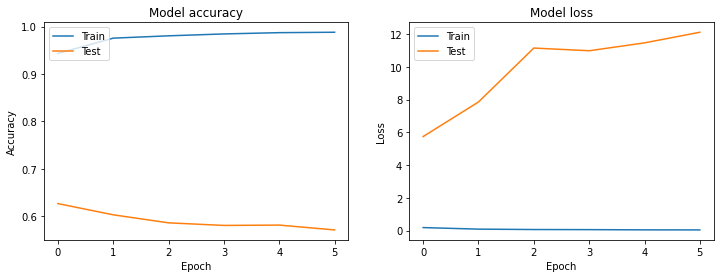

In [ ]:
output_metrics(model13,history13,X_test2, y_test3)

* Nesta situação a performance global é de 59%, com um recall 99% no COVID. O modelo garante o mínimo de falsos negativos COVID, mas apresenta lobalmente erros elevados.

* Observa-se ainda elevado overfitting, apesar das camadas de dropout usadas.


---


Quanto à utilização de transfer learning para prever o COVID foi obtido apenas um modelo interessante:

* usar a arquitetura da rede InnceptionRedNetV2, mas re-treinando os pesos. 

---

